In [1]:
import numpy as np
import pandas as pd
import pytz
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction to Business Analytics - Task 1

Cluster the users based on their usage patterns - users with similar usage behaviors 
(e.g., charging more on the weekends, or more in daytime vs. nighttime) should be 
grouped together. The goal is to segment the user base, such that you can try to 
identify a target audiency for the company’s upcoming ad campaigns. (Important: 
note that the dataset provided contains charging events - you will have to transform 
that data into hourly energy use and hourly charger occupation for this analysis and 
also for Task 2). In the end, you should be able to provide recommendations to the 
company – you will not be evaluated on that recommendation, but on the appropriate 
usage of the techniques that you learned in class to achieve that recommendation. 
Make sure to clearly motivate your choices along the way!

### Data preparation

By taking a look at our dataset (for example by using "df.info()"):

In [2]:
# Importing the dataset
df = pd.read_csv("EVChargingStationUsage.csv", low_memory=False)
#df.info()

* We can see that all rows count with date/time information, including time zones. These will be converted to proper date/time formats. Times expressed in UTC will be later converted to a local (US/Pacific) time.  
* Some rows do not count with an User Identification: We will drop these, as we are trying to cluster the users.
* Many features such as 'Currency', 'Gasoline Savings', 'MAC address', among others will be considered irrelevant and will be dropped from the dataframe.

In [3]:
# Dropping duplicates, if any
df = pd.read_csv("EVChargingStationUsage.csv", low_memory=False)
df = df.drop_duplicates()

# Covert dates and times to proper format
df['Start Date'] = pd.to_datetime(df['Start Date'])
#df['Start Date'] = df['Start Date'].dt.tz_localize('Europe/Paris')
df['Charging Time (hh:mm:ss)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)'])
df['Total Duration (hh:mm:ss)'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)'])

# If 'Start Date' falls on a weekend day, set 1. If not, set 0
df['Charging_on_weekend'] = (df['Start Date'].dt.dayofweek >= 5).astype(int)

# Dropping of features that do not contribute directly to understanding user charging behavior patterns
df = df.drop(['Station Name', 'MAC Address', 'End Time Zone', 'Transaction Date (Pacific Time)', 'End Date',
             'Org Name','Currency', 'Fee','GHG Savings (kg)','Gasoline Savings (gallons)','Port Type', 'Port Number',
            'Plug Type','Address 1','City','State/Province','Ended By','System S/N','Model Number','County',
             'Driver Postal Code', 'EVSE ID','Postal Code', 'Country','Plug In Event Id','Latitude','Longitude'], axis=1)

# Drop the User IDs that do not have a numerical value
df['User ID'] = pd.to_numeric(df['User ID'], errors='coerce') # 'coerce' will set 'User ID' to NaN if not numeric 
df = df.dropna(subset=['User ID']) # Dropping all NaN entries
df

,Start Date,Start Time Zone,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),User ID,Charging_on_weekend
0,2011-07-29 20:17:00,PDT,0 days 03:03:32,0 days 01:54:03,6.249457,3284.0,0
1,2011-07-30 00:00:00,PDT,0 days 00:02:06,0 days 00:01:54,0.106588,4169.0,1
2,2011-07-30 08:16:00,PDT,0 days 04:17:32,0 days 04:17:28,14.951777,4169.0,1
3,2011-07-30 14:51:00,PDT,0 days 02:03:24,0 days 02:02:58,7.159643,2545.0,1
4,2011-07-30 18:51:00,PDT,0 days 01:11:24,0 days 00:43:54,1.957765,3765.0,1
...,...,...,...,...,...,...,...
259410,2020-12-31 16:39:00,PST,0 days 00:35:44,0 days 00:35:18,1.841000,2024201.0,0
259411,2020-12-31 16:48:00,PST,0 days 03:43:01,0 days 02:14:04,12.744000,242661.0,0
259412,2020-12-31 17:28:00,PST,0 days 17:28:14,0 days 05:08:12,29.665000,449995.0,0
259413,2020-12-31 17:49:00,PST,0 days 04:05:34,0 days 03:53:42,11.976000,804075.0,0


### Data transformation

We would like to transform our current data frame so that we can analyze each user's **energy use** and **charger occupation** per hour.

We proceed to populate a new data frame, distributing both the energy use and charger occupation (in hours) in 24 time intervals for each of the hours of the day.

In [4]:
# Note: It might take up to 2-3 mins to populate the data frames
# Listing all unique user IDs

users = df['User ID'].unique()
users = np.sort(users)

# Generating two empty dictionaries (later to become one single data frame) to populate:
df_energy = {user: {str(hour): 0 for hour in range(24)} for user in users} 
df_occupation = {user: {str(hour)+" occ": 0 for hour in range(24)} for user in users}

# Additional list to keep track of the user's use of the charger during weekend days
weekend_usage = df.groupby('User ID')['Charging_on_weekend'].mean()

# Go through each entry in the provided database
for _, row in df.iterrows():
    
    id = row['User ID']
    start = row['Start Date']

    if row['Start Time Zone'] == 'UTC': # Convert to local US Pacific time if the starting date is in UTC
        start = start.tz_localize('UTC').tz_convert('US/Pacific')

    # Hourly energy use
    charging_time = row['Charging Time (hh:mm:ss)']
    end = start + charging_time
    energy = row['Energy (kWh)']
    energy_per_hour = energy / (charging_time.total_seconds() / 3600)

    if charging_time <= pd.to_timedelta(start.ceil(freq='h') - start): # If charging time starts and ends within the same hour
        df_energy[id][str(start.hour)] += energy

    else: # If start and end dates do not fall within the same hour
        df_energy[id][str(start.hour)] += energy_per_hour * pd.to_timedelta(start.ceil(freq='h') - start) / np.timedelta64(1, 'h')
        full_hours = int(pd.to_timedelta(end.ceil(freq='h') - start.floor(freq='h')) / np.timedelta64(1, 'h'))
        for hour in range(start.hour + 1, start.hour + full_hours - 1):
            df_energy[id][str(hour % 24)] += energy_per_hour
        df_energy[id][str(end.hour)] += energy_per_hour * pd.to_timedelta(end - end.floor(freq='h')) / np.timedelta64(1, 'h')

    # Hourly charger occupation
    occupation_time = row['Total Duration (hh:mm:ss)']
    end = start + occupation_time

    if occupation_time <= pd.to_timedelta(start.ceil(freq='h') - start): # If occupation time starts and ends within the same hour
        df_occupation[id][str(start.hour)+" occ"] += occupation_time / np.timedelta64(1, 'h')

    else: # If start and end dates do not fall in the same hour
        df_occupation[id][str(start.hour)+" occ"] += pd.to_timedelta(start.ceil(freq='h') - start) / np.timedelta64(1, 'h')
        full_hours = int(pd.to_timedelta(end.ceil(freq='h') - start.floor(freq='h')) / np.timedelta64(1, 'h'))
        for hour in range(start.hour + 1, start.hour + full_hours - 1):
            df_occupation[id][str(hour % 24)+" occ"] += 1
        df_occupation[id][str(start.hour)+" occ"] += pd.to_timedelta(end - end.floor(freq='h')) / np.timedelta64(1, 'h')

df_energy = pd.DataFrame(df_energy).T # Tranform dictionary to pandas dataframe
df_energy.index.name = 'User ID' # Set 'User ID' as index feature

df_occupation = pd.DataFrame(df_occupation).T # Tranform dictionary to pandas dataframe
df_occupation.index.name = 'User ID' # Set 'User ID' as index feature

We have obtained two dataframes with information of each user's hourly energy use and hourly charger occupation for each of 24 one-hour time periods of the day. We can visualize the time series in two different plots.

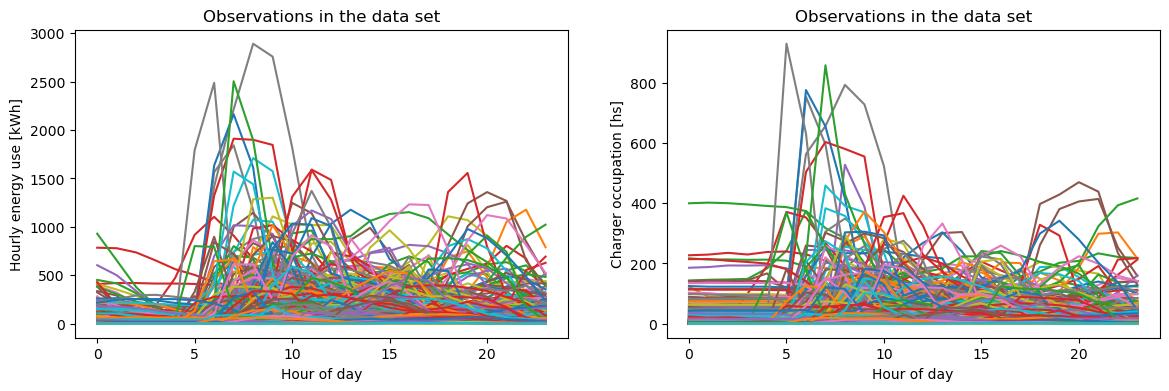

In [525]:
# Plot observations
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1 - Energy use vs. Time
axs[0].plot(df_energy.T)
axs[0].set_title('Observations in the data set')
axs[0].set_xlabel('Hour of day')
axs[0].set_xticks([0,5,10,15,20], [0,5,10,15,20])
axs[0].set_ylabel('Hourly energy use [kWh]')

# Plot 2 - Hourly charger occupation vs. Time
axs[1].plot(df_occupation.T)
axs[1].set_title('Observations in the data set')
axs[1].set_xlabel('Hour of day')
axs[1].set_xticks([0,5,10,15,20], [0,5,10,15,20])
axs[1].set_ylabel('Charger occupation [hs]')

plt.show()

As expected, with so many users it is hard (if not impossible) to group them or to visualize any pattern. We thus proceed to merge the hourly energy use and charger occupation in order to apply a clustering algorithm.

In [738]:
# Merging the two dataframes
dt = pd.concat([df_energy, df_occupation], axis=1)
dt.head(3)

,0,1,2,3,4,5,6,7,8,9,...,14 occ,15 occ,16 occ,17 occ,18 occ,19 occ,20 occ,21 occ,22 occ,23 occ
User ID,,,,,,,,,,,,,,,,,,,,,
0.0,65.44263,45.26083,26.776014,8.612861,4.75552,7.134919,19.825794,50.138669,104.372049,194.612826,...,59.284722,51.782222,52.166111,64.903611,88.168889,90.126944,71.012778,61.1075,39.779722,34.618889
102.0,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.458611,2.000000,1.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000
107.0,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.427443,...,0.731111,0.000000,0.000000,0.000000,0.666389,2.295556,2.000000,0.0000,0.000000,0.000000


Since energy consumption (kWh) and charger occupation (hours) are on different scales, we should standardize the data so that no single feature dominates the clustering process.

In [741]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dt_scaled = scaler.fit_transform(dt)

We opt to use **k-means** for our analysis. The number of clusters will be determined using the elbow method. This method involves plotting the sum of squared errors (between each point and the mean of its cluster) as a function of k and looking at
 where the graph bends. In *sklearn*, the attribute *inertia_* returns the sum of squared distances of samples to their closest cluster center.”

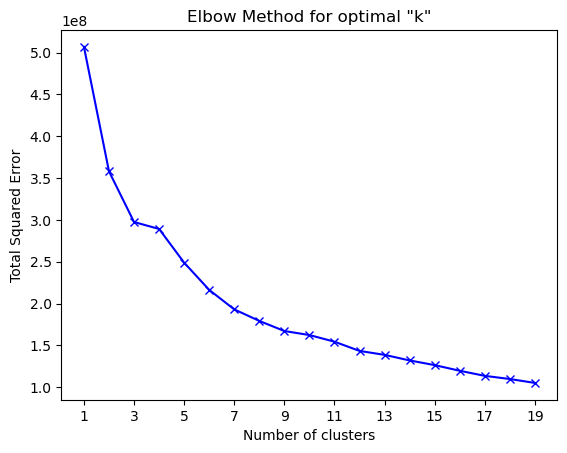

In [744]:
from sklearn.cluster import KMeans

total_error, k_range = [], 20

for k in range(1, k_range):
    kmeans = KMeans(n_clusters = k).fit(dt_scaled)
    total_error.append(kmeans.inertia_)

plt.plot(range(1, k_range), inertia, 'bx-')
plt.title('Elbow Method for optimal "k"')
plt.xlabel('Number of clusters')
plt.xticks([i for i in range(1, k_range,2)], [i for i in range(1, k_range,2)])
plt.ylabel('Total Squared Error')
plt.show()

Clusters above k = 8 seem not to offer a significant reduction in the total squared error, as observed in the elbow method. We proceed to choose k = 8 as the number of clusters for this task. Choosing a lower value of k, such as k = 5, could have been a valid alternative, but it might oversimplify the interpretation of user behaviours, merging distinct patterns into overly broad groups. For our large dataset, a value of k = 8 may be able to capture interesting user behaviour patterns while mantaining interpretability.

In [788]:
# We define eight clusters and fit the scaled data
K = 8
kmeans = KMeans(n_clusters = K, random_state=42) # Random state sets consistency for multiple runs of the code
kmeans.fit(dt_scaled)

KMeans(random_state=42)

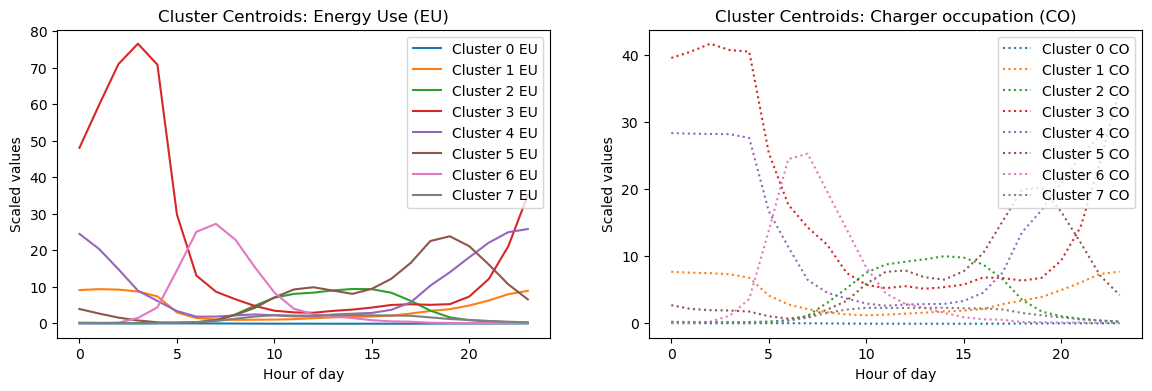

In [1009]:
# Plot observations
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    axs[0].plot(range(24), centroid[:24], label=f"Cluster {cluster_idx} EU")
    axs[1].plot(range(24), centroid[24:], linestyle="dotted", label=f"Cluster {cluster_idx} CO")

axs[0].set_title("Cluster Centroids: Energy Use (EU)")
axs[0].set_xlabel('Hour of day')
axs[0].set_ylabel("Scaled values")
axs[0].legend(loc=1)

axs[1].set_title("Cluster Centroids: Charger occupation (CO)")
axs[1].set_xlabel('Hour of day')
axs[1].set_ylabel("Scaled values")
axs[1].legend(loc=1)

plt.show()

### Clusters interpretation

We can already see patterns in every cluster. Before we proceed to a final analysis, it might be a good idea to see if there is any relationship between the clusters and the use of charger during the weekends. We had created a list before, named *weekend_usage*, to keep track of each user's use of the charger during weekend days. 

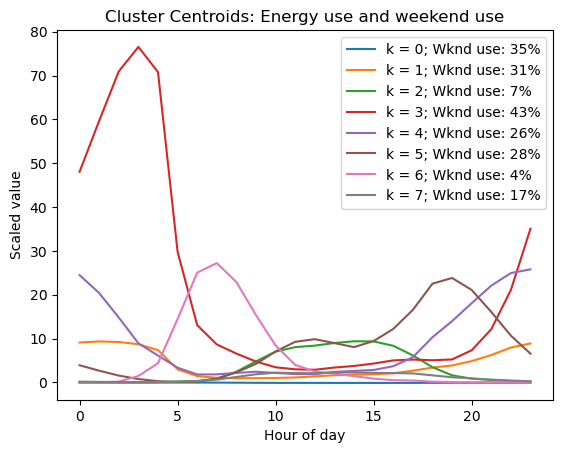

In [998]:
# Create a copy of the scaled dataset and assign the predicted cluster number for each user
df_clusters = pd.DataFrame(dt)
df_clusters['Cluster'] = kmeans.fit_predict(dt_scaled)
df_clusters['Weekend usage'] = np.array(weekend_usage)

# For every cluster, show the hourly energy use and the mean weekend use 
for i in range(K):
    plt.plot(x, kmeans.cluster_centers_[i][0:24], label = f'k = {i}; Wknd use: {int(np.mean(df_clusters[df_clusters.Cluster==i]['Weekend usage']*100))}%')
plt.title("Cluster Centroids: Energy use and weekend use")
plt.xlabel('Hour of day')
plt.ylabel('Scaled value')
plt.legend();

We can also identify the amount of users that lie in each cluster:

In [1000]:
users_per_cluster = df_clusters.groupby('Cluster').size()
users_per_cluster = pd.DataFrame(a)
users_per_cluster.columns = ['Users']
users_per_cluster

,Users
Cluster,
0,20647
1,71
2,104
3,1
4,14
5,16
6,17
7,550


With this information, we are ready to give insights from each cluster and provide recommendations to the EV charger company. They are summarized in the following table:

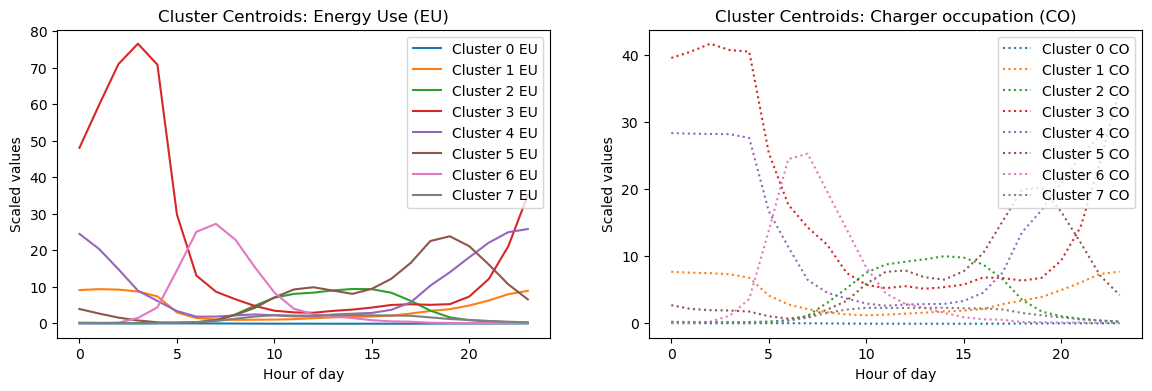

In [1013]:
fig

| Cluster | Users  | Energy Use Behaviour                              | Charger Occupation Behaviour                         | Weekend Use         | Insights                                                                 | Recommendations                                                                                                                                  |
|---------|--------|--------------------------------------------------|----------------------------------------------------|---------------------|--------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **0**   | 20,647 | Very low energy use throughout the whole day.    | Charger occupation remains very low throughout the whole day. | 36% of users charge on weekends. | Represents a large group of low-energy users who are occasional or casual EV users.                        | Focus on **engagement campaigns** to increase charging frequency, such as rewards or discounts for weekday use. Ensure chargers in residential areas are visible and accessible. |
| **1**   | 71     | Energy use is moderate during the night (8 PM - 5 AM). | Charger occupation aligns with energy use, peaking during the early morning. | 31% charge on weekends. | Likely overnight residential users.                                                    | Expand nighttime charging infrastructure in **residential areas** and ensure reliable service during those hours. Consider offering **nighttime charging discounts**. |
| **2**   | 104    | Energy use is moderate during office hours (9 AM - 5 PM). | High charger occupation also during office hours.  | 7% charge on weekends.  | Likely users who occupy chargers during office working hours from Monday to Friday.                        | Target workplace charging programs by installing chargers near office hubs. Promote **lunchtime charging deals** to encourage off-peak use. |
| **3**   | 1      | Very high energy use during early morning hours (2 AM - 6 AM). | Charger occupation spikes similarly in early morning hours. | 43% of weekend use.    | Outlier unique user with many charging events.                                                             | Investigate this unique user for potential **special fleet vehicle** requirements or data anomalies. Consider reallocating this user into another cluster or analyzing them separately. |
| **4**   | 14     | High energy use during evening and nighttime (5 PM - 5 AM). | High charger occupation during the night aligns with energy use. | 26% charge on weekends. | Overnight users. Possible concentration of hoarders.                                                      | Ensure availability of **overnight chargers** near residential hubs. Introduce policies to limit extended use (hoarding). Educate users about fair usage practices. |
| **5**   | 16     | Moderate energy use with dual peaks: morning (9 AM - 10 AM) and evening (6 PM - 8 PM). | Charger occupation also peaks during morning and evening hours. | 29% charge on weekends. | Represents users who follow commute-focused charging patterns, both in residential and workplace areas.   | Expand infrastructure along **commuter routes** and near workplaces. Promote time-based incentives to avoid simultaneous morning/evening peaks. |
| **6**   | 17     | High energy use during the mornings (5 AM - 10 AM). | Corresponding charger occupation is high during those same hours. | 4% charge on weekends.  | May represent low-usage users. Possible concentration of hoarders.                                         | Focus on **maintenance and monitoring** for early morning chargers. Introduce education campaigns to deter hoarding and promote efficient charging. |
| **7**   | 550    | Low energy use during office hours (9 AM - 5 PM). | Charger occupation is also low.                    | 18% charge on weekends. | Low energy use consumers, usually driving from Monday to Friday.                                           | Encourage weekday charging with **corporate partnerships** or commuter plans. Improve visibility of chargers near office and transit hubs. |
